In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy import ndimage
import matplotlib.pyplot as plt
import random
import matplotlib.dates as mdates

In [2]:
!pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
import mplfinance as mpf

# 1. Data Loading and Exploration

In [4]:
apple_df = pd.read_csv('Apple Stock Prices (1981 to 2023).csv')

In [5]:
# show first 5 rows
apple_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/1981,0.154018,0.155134,0.154018,0.154018,0.119849,21660800
1,05/01/1981,0.151228,0.151228,0.150670,0.150670,0.117244,35728000
2,06/01/1981,0.144531,0.144531,0.143973,0.143973,0.112032,45158400
3,07/01/1981,0.138393,0.138393,0.137835,0.137835,0.107256,55686400
4,08/01/1981,0.135603,0.135603,0.135045,0.135045,0.105085,39827200


In [6]:
# check the data type of columns
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10608 entries, 0 to 10607
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10608 non-null  object 
 1   Open       10608 non-null  float64
 2   High       10608 non-null  float64
 3   Low        10608 non-null  float64
 4   Close      10608 non-null  float64
 5   Adj Close  10608 non-null  float64
 6   Volume     10608 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 580.3+ KB


In [49]:
# convert column 'Date' from object to datetime format
apple_df['Date'] = pd.to_datetime(apple_df['Date'], errors = 'coerce')

# delete rows with missing values
apple_df = apple_df.dropna(subset=['Date'])

KeyError: 'Date'

In [8]:
# we have a lot of missing values for column date - > 50%
# but where is no data we have value Nat and that will not interfere

apple_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
# set 'Date' as index

apple_df = apple_df.set_index('Date')

# check the frequency 

print(apple_df.index.inferred_freq)

None


#### Why we can not count inferred frequences
The inferred frequency is None due to non-trading days (weekends and holidays),
but the data is effectively daily stock data.

In [10]:
# before build chart with trends, we have to count mean by months

df_monthly = apple_df.resample('ME').mean()

In [11]:
# check for missing values
df_monthly.isna().sum()

Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [15]:
# we have four months that has no data, so it would be logical to fill them with the data of the previous month

df_monthly_filled = df_monthly.fillna(method='ffill')

C:\Users\User\AppData\Local\Temp\ipykernel_42540\141092960.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_monthly_filled = df_monthly.fillna(method='ffill')


In [16]:
# check for missing values after fillna
df_monthly_filled.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# 2. Data Visualization

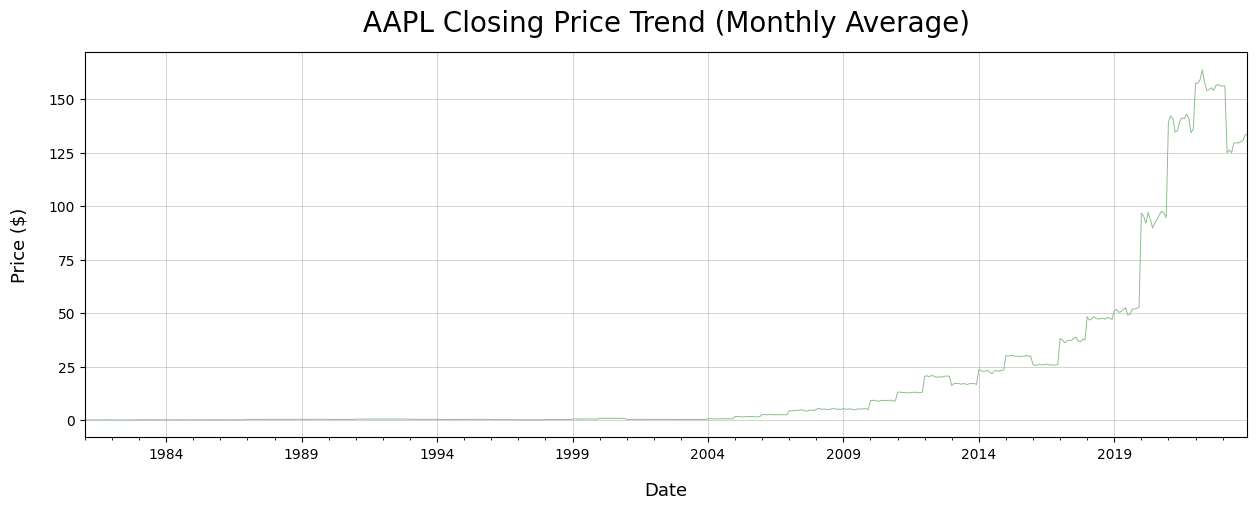

In [17]:
# Closing Prices Over Time

df_monthly_filled['Close'].plot(figsize=(15, 5), color = 'darkseagreen', linewidth = 0.7)
plt.title('AAPL Closing Price Trend (Monthly Average)', fontsize = 20, pad = 15)
plt.xlabel('Date', fontsize = 13, labelpad = 15)
plt.ylabel('Price ($)', fontsize = 13, labelpad = 15)

plt.grid(linewidth = 0.4)

plt.show()

#### Conclusions:
- Apple`s stock prices began to grow in 2004 when Steve Jobs represented the first iPod
- With each passing year, the stock prices gradually grew
- Despite of the pandemia, there was a significant jump in Apple stock prices in 2020 and 2021 years. They launched a lot of new products and redesigned sum of their product
- Apple`s stock prices continud to grow until 2023 and then they fell from 160 to 125$
- After 2023 stock prices started growing again

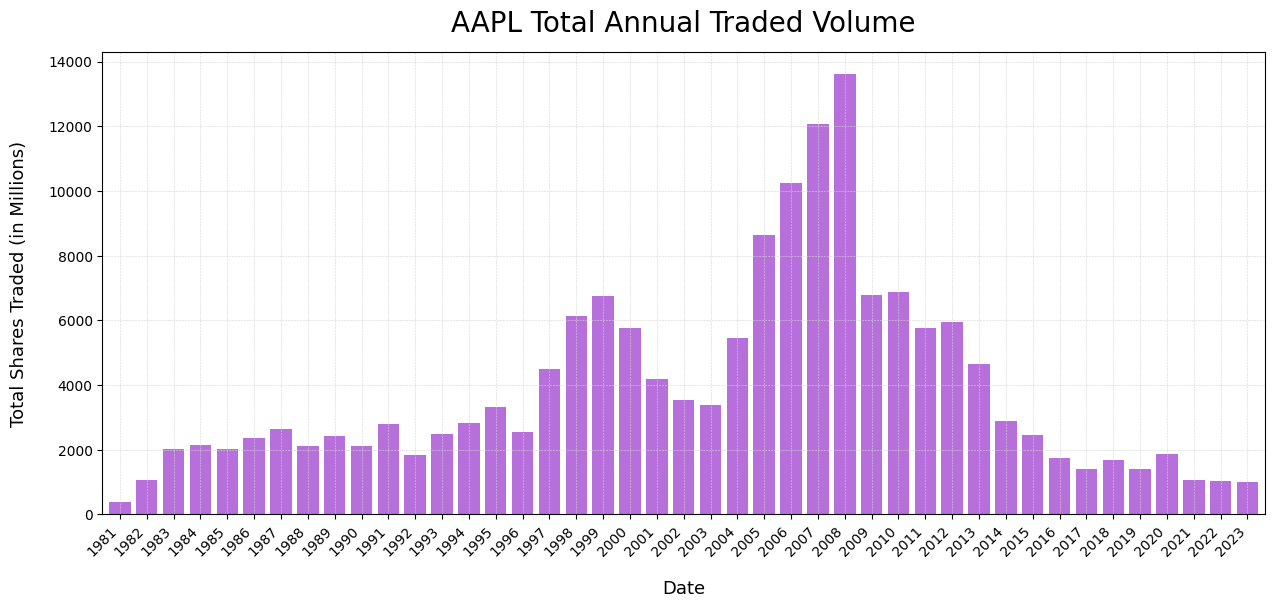

In [18]:
# Traded Volume Over Time

# create a new variable with year mean
df_yearly = df_monthly_filled.resample('YE').sum()

fig, ax = plt.subplots(figsize=(15, 6))

df_yearly['Volume'].plot(ax=ax, kind = 'bar', width=0.8, color='darkorchid', alpha=0.7)
plt.title('AAPL Total Annual Traded Volume', fontsize = 20, pad = 15)
plt.xlabel('Date', fontsize = 13, labelpad = 15)
plt.ylabel('Total Shares Traded (in Millions)', fontsize = 13, labelpad = 15)

# formate axis y (millions)
# (divede values of y by 1,000,000)
def millions_formatter(x, pos):
    return f'{x / 1000000:.0f}'
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# Determine all column positions (0, 1, 2, 3, ...)
tick_positions = np.arange(len(df_yearly.index))
# Determine text for all columns
# Formate index only like year
tick_labels = [date.strftime('%Y') for date in df_yearly.index]
# Set a step
# Create an array of positions starting from 0
step = 1
selected_positions = tick_positions[::step]
selected_labels = tick_labels[::step]
# Applying labels to a chart
ax.set_xticks(selected_positions)
ax.set_xticklabels(selected_labels, rotation=45, ha='right')

plt.grid(linewidth = 0.4, color = 'lightgray', linestyle = '--')

plt.show()

#### Conclusion:
- Despite consistent stock price appreciation, the highest trading volumes were recorded exclusively between 2005 and 2008.
- Current trading volumes are significantly lower compared to the peak period of 2005–2008.

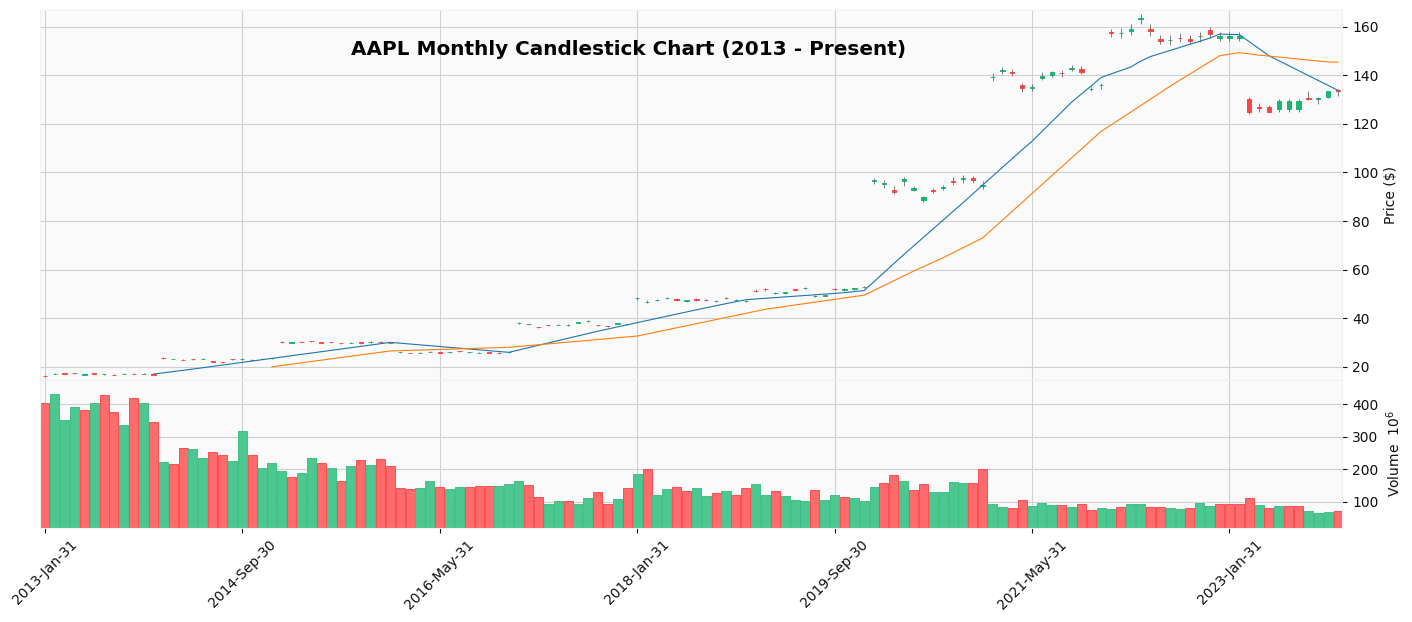

In [27]:
# Candlestick chart to depict high and low prices

# 1. Data Filtering: From January 1, 2013 to Present
# (Assumes df_monthly_filled has a DatetimeIndex index)
df_recent = df_monthly_filled.loc['2013-01-01':] 

# 2. Plotting a chart with mplfinance
mpf.plot(
    df_recent,
    type='candle',          # Candlestick chart
    style='yahoo',          # Style
    figsize=(15, 6),
    title='AAPL Monthly Candlestick Chart (2013 - Present)',
    ylabel='Price ($)',
    volume=True,            # Adding a Volume chart below for context
    mav=(12, 24),           # Adding 12- and 24-month moving averages for trend analysis
    xrotation=45,
    tight_layout=True
)

#### Conclusions:
- Over the past 10 years, the trend has been predominantly sideways, alternating with an uptrend, indicating that the market is awaiting a breakout.
- Green candlesticks predominate, indicating rising prices, but declines are also observed.
- The last candlestick is hammer-shaped, signaling a possible upward reversal, as sellers were unable to hold the low price.

# 3. Statistical Analysis

In [34]:
# Summary statistics (mean, median, standard deviation) for 'Open'

open_mean = df_monthly_filled['Open'].mean().round(1) # mean
open_median = df_monthly_filled['Open'].median().round(1) # median
open_std = df_monthly_filled['Open'].std().round(1) # standard deviation

print(f'''For 'Open' column:
Mean : {open_mean}
Median : {open_median}
Standard Deviation : {open_std}''')

For 'Open' column:
Mean : 19.2
Median : 0.5
Standard Deviation : 38.8


In [35]:
# Summary statistics (mean, median, standard deviation) for 'High'

high_mean = df_monthly_filled['High'].mean().round(1) # mean
high_median = df_monthly_filled['High'].median().round(1) # median
high_std = df_monthly_filled['High'].std().round(1) # standard deviation

print(f'''For 'High' column:
Mean : {high_mean}
Median : {high_median}
Standard Deviation : {high_std}''')

For 'High' column:
Mean : 19.4
Median : 0.5
Standard Deviation : 39.3


In [36]:
# Summary statistics (mean, median, standard deviation) for 'Low'

low_mean = df_monthly_filled['Low'].mean().round(1) # mean
low_median = df_monthly_filled['Low'].median().round(1) # median
low_std = df_monthly_filled['Low'].std().round(1) # standard deviation

print(f'''For 'Low' column:
Mean : {low_mean}
Median : {low_median}
Standard Deviation : {low_std}''')

For 'Low' column:
Mean : 19.0
Median : 0.5
Standard Deviation : 38.3


In [37]:
# Summary statistics (mean, median, standard deviation) for 'Close'

close_mean = df_monthly_filled['Close'].mean().round(1) # mean
close_median = df_monthly_filled['Close'].median().round(1) # median
close_std = df_monthly_filled['Close'].std().round(1) # standard deviation

print(f'''For 'Close' column:
Mean : {close_mean}
Median : {close_median}
Standard Deviation : {close_std}''')

For 'Close' column:
Mean : 19.2
Median : 0.5
Standard Deviation : 38.8


In [38]:
# Summary statistics (mean, median, standard deviation) for 'Adj Close'

ad_close_mean = df_monthly_filled['Adj Close'].mean().round(1) # mean
ad_close_median = df_monthly_filled['Adj Close'].median().round(1) # median
ad_close_std = df_monthly_filled['Adj Close'].std().round(1) # standard deviation

print(f'''For 'Adj Close' column:
Mean : {ad_close_mean}
Median : {ad_close_median}
Standard Deviation : {ad_close_std}''')

For 'Adj Close' column:
Mean : 18.5
Median : 0.4
Standard Deviation : 38.5


In [39]:
# Summary statistics (mean, median, standard deviation) for 'Volume'

volume_mean = df_monthly_filled['Volume'].mean().round(1) # mean
volume_median = df_monthly_filled['Volume'].median().round(1) # median
volume_std = df_monthly_filled['Volume'].std().round(1) # standard deviation

print(f'''For 'Volume' column:
Mean : {volume_mean}
Median : {volume_median}
Standard Deviation : {volume_std}''')

For 'Volume' column:
Mean : 321602886.1
Median : 219920950.0
Standard Deviation : 256841963.9


In [40]:
# Analyze closing prices with a moving average
# make averages for column 'Close'

df_monthly_filled['MA_12'] = df_monthly_filled['Close'].rolling(window = 12).mean() # moving average for 12 months
df_monthly_filled['MA_36'] = df_monthly_filled['Close'].rolling(window = 36).mean() # moving average for 36 months

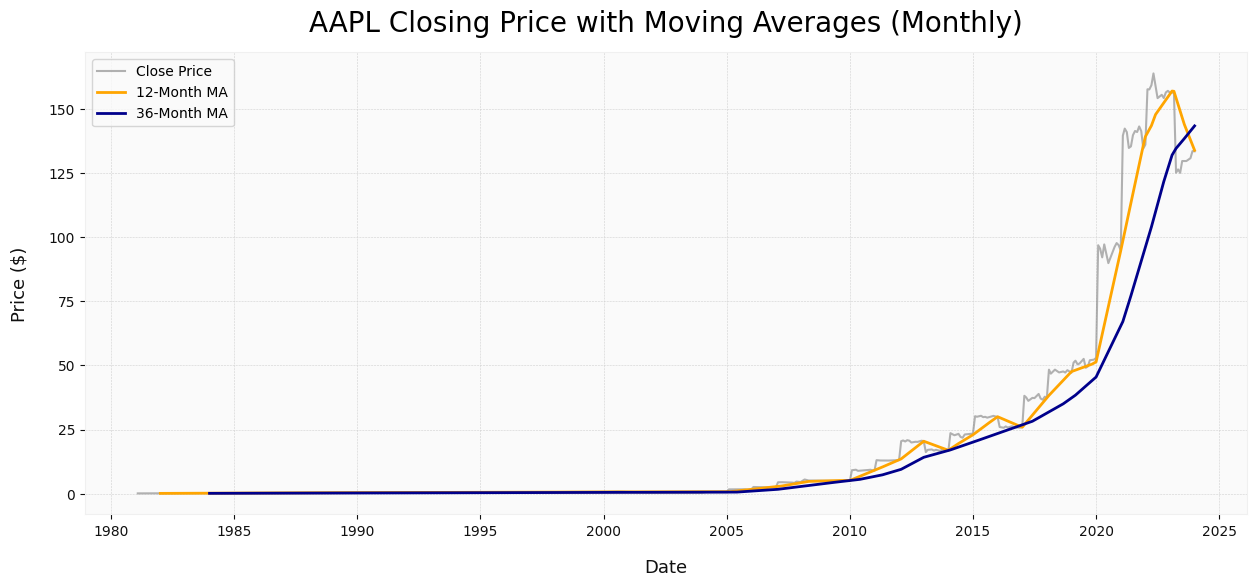

In [42]:
#Plote a chart

plt.figure(figsize = (15, 6))

# 1. Close Price Line
plt.plot(
    df_monthly_filled.index,         # axis x
    df_monthly_filled['Close'],      # axis y
    label='Close Price',
    color='gray',
    alpha=0.6,
    linewidth=1.5
)

# 2. MA_12 line
plt.plot(
    df_monthly_filled.index,
    df_monthly_filled['MA_12'],
    label='12-Month MA',
    color='orange',
    linewidth=2
)

# 3. MA_36 line
plt.plot(
    df_monthly_filled.index,
    df_monthly_filled['MA_36'],
    label='36-Month MA',
    color='darkblue',
    linewidth=2
)

plt.title('AAPL Closing Price with Moving Averages (Monthly)', fontsize=20, pad=15)
plt.xlabel('Date', fontsize=13, labelpad=15)
plt.ylabel('Price ($)', fontsize=13, labelpad=15)
plt.legend(loc='upper left')
plt.grid(linewidth=0.4, linestyle='--')

plt.show()

**Conclusions**:
- From 2017 to 2021, Apple's stock (asset) was in an upward trend (or, "was exhibiting a bullish trend").
- A downward trend (or, "a bearish trend") was observed from 2021 to 2023, but the stock began to rise in 2023.
- However, a sell signal was observed in 2023, indicating the beginning of a long-term downward trend (the 12-month moving average crossed the 36-month moving average from above to below).
- Primarily, the 12-month moving average acted as close support for the upward trend since 2010.

# 4. Hypothesis Testing
We will compare the average closing price for 2017 (strong growth) and 2023 (more volatile period).

In [47]:
# make variables for 2017 and 2023 years

close_2017 = apple_df.loc['2017']['Close'].dropna()
close_2023 = apple_df.loc['2023']['Close'].dropna()

# t-test
t_stat, p_value = stats.ttest_ind(close_2017, close_2023)
 
print(f'''t-test results (2017 vs 2023):
Average close price 2017: ${close_2017.mean():.2f}
Average close price 2023: ${close_2023.mean():.2f}
T-stats: {t_stat:.4f}
P-value: {p_value:.4e}''')

t-test results (2017 vs 2023):
Average close price 2017: $37.43
Average close price 2023: $129.23
T-stats: -66.2090
P-value: 7.5549e-87


**Conclusoin**:
- There are significant differences in close prices in 2017 and 2023 years (P-value: 7.5549e-87)

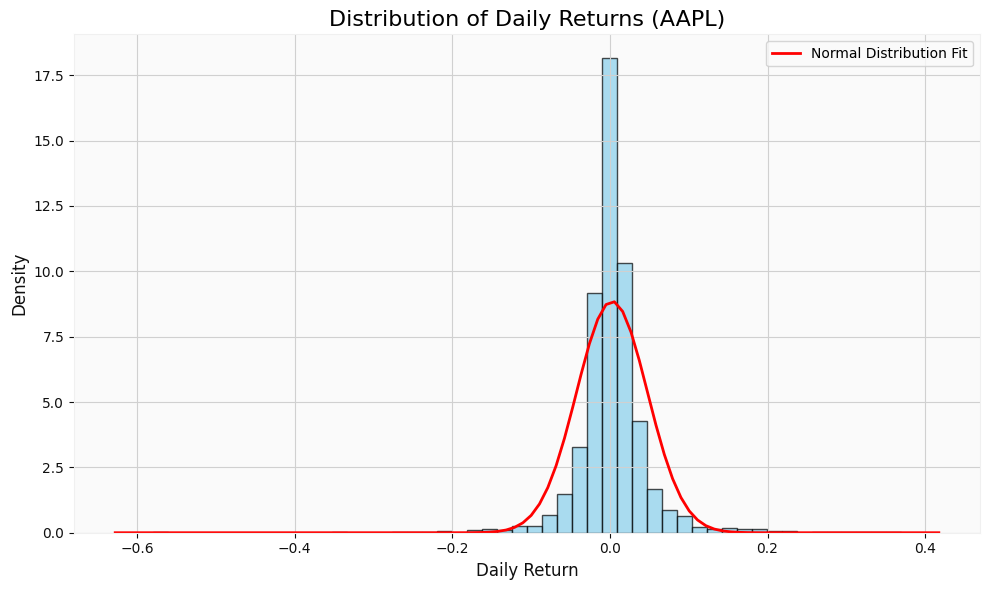

In [67]:
# daily returns’ distribution and test for normality

# Count Daily Returns 
apple_df['Returns'] = apple_df['Close'].pct_change()
apple_df = apple_df.dropna(subset=['Returns'])

# Visualization
plt.figure(figsize=(10, 6))
apple_df['Returns'].hist(bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Overlaying a normal distribution for comparison
mu, std = stats.norm.fit(apple_df['Returns'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution Fit')

plt.title('Distribution of Daily Returns (AAPL)', fontsize=16)
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('daily_returns_distribution.png')
plt.show()  
plt.close()

In [66]:
# D'Agostino-Pearson's Test
k2, p_normality = stats.normaltest(apple_df['Returns'])
print(f'''D'Agostino-Pearson's Test (K^2): {k2:.4f}
P-value: {p_normality:.4e}''')

D'Agostino-Pearson's Test (K^2): 1104.8975
P-value: 1.1873e-240


**Conclusion**:
- The distribution of returns is STATISTICALLY SIGNIFICANTLY DIFFERENT from normal.
- This is typical for financial data: 'heavy tails' (more frequent extreme events).

# Summary, Insights and Reflection

### Summary of Findings
- Apple's stock demonstrated significant and sustained growth since 2004, catalyzed by the release of the iPod and subsequent product line expansion. This growth continued even during the pandemic (2020-2021), marking a substantial price jump. Despite a recent dip in 2023 (from 160 to 125 dollars), prices quickly recovered, affirming the overall strength of the uptrend. Statistical analysis confirmed the extremely high significance of the difference in closing prices between 2017 and 2023.
- Notably, the highest trading volumes were recorded during a relatively early period (2005–2008), while current volumes are significantly lower. This may suggest a change in the nature of stock ownership, potentially shifting toward long-term institutional investors.

**Key insights**:
- The Power of Brand and Innovation: Stock price appreciation since 2004 directly correlates with the introduction of new products (iPod) and successful management during crises (2020-2021). This confirms that fundamental innovation is the primary driver of Apple's stock value.

- Uncertainty in the Current Trend: Over the past 10 years, the price movement has been predominantly sideways, alternating with an uptrend. According to technical analysis, this suggests the market is awaiting a breakout or a strong new price movement.

- Conflicting Technical Signals:

  - The "Hammer" candlestick signal indicates a possible bullish reversal in the short term.

  - However, the "Sell Signal" observed in 2023 (the 12-month moving average crossing the 36-month moving average from above) suggests the potential start of a long-term bearish trend. This presents a contradiction: short-term optimism versus long-term pessimism, demanding careful monitoring.

- Non-Normality of Returns (Risks): The presence of "heavy tails" in the return distribution is typical for financial markets, but it holds significant practical implications. It means that extreme events (sharp gains or drops) occur substantially more often than predicted by the normal distribution. This increases the inherent risk associated with holding the asset.

#### Reflection and Future Considerations
- Apple's stock is at a critical juncture. On one hand, fundamental growth, resilience, and the historical role of the 12-month moving average as support since 2010 argue for the strength of the bull market. On the other hand, the sell signal from long-term moving averages and the lower current trading volumes (compared to the 2005-2008 peak) might indicate that the asset has reached maturity and could face deceleration.

- It is crucial for investors to monitor which signal will dominate:

  - Will the Hammer be confirmed by further price growth (a resumption of the bullish trend)?

  - Or do the sell signal from the moving averages and the sideways trend predict a prolonged period of consolidation or a deep correction?

- The non-normality of the return distribution necessitates the use of more sophisticated risk management models (such as Value at Risk, accounting for heavy tails) rather than relying on standard metrics based on the normal distribution.